In [1]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2DTranspose

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D

from tensorflow.keras.layers import BatchNormalization

from tensorflow import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

2022-02-20 19:04:12.014229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-20 19:04:12.014267: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Látens tér dimenziószáma
latent_dim = 512

# Bemeneti zaj generálása
noise = random.normal([1, latent_dim])

2022-02-20 19:04:14.194600: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-20 19:04:14.194655: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-20 19:04:14.194699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Inspiron-5558): /proc/driver/nvidia/version does not exist
2022-02-20 19:04:14.195274: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def add_upsampling_unit(model, units):
    model.add(UpSampling2D())
    model.add(
        Conv2D(filters=units[0], kernel_size=(3, 3),
               padding='same', activation="leaky_relu")
    )
    model.add(
        Conv2D(filters=units[1], kernel_size=(3, 3),
               padding='same', activation="leaky_relu")
    )

def make_generator_model(latent_dim):
    model = Sequential()
    
    # out: 4x4x512
    model.add(Reshape((1, 1, latent_dim), input_shape=[latent_dim]))
    model.add(
        Conv2DTranspose(filters=512, kernel_size=(4, 4),
                        strides=(2, 2), padding="valid",
                        activation="leaky_relu")
    )
    model.add(
        Conv2D(filters=512, kernel_size=(3, 3),
               padding='same', activation="leaky_relu")
    )
    assert model.output_shape == (None, 4, 4, 512)
    
    # out: 8x8x512
    add_upsampling_unit(model, (512, 512))
    assert model.output_shape == (None, 8, 8, 512)
    
    # out: 16x16x512
    add_upsampling_unit(model, (512, 512))
    assert model.output_shape == (None, 16, 16, 512)
    
    # out: 32x32x512
    add_upsampling_unit(model, (512, 512))
    assert model.output_shape == (None, 32, 32, 512)
    
    # out: 64x64x256
    add_upsampling_unit(model, (256, 256))
    assert model.output_shape == (None, 64, 64, 256)
    
    # out: 128x128x128
    add_upsampling_unit(model, (128, 128))
    assert model.output_shape == (None, 128, 128, 128)
    

    model.add(Conv2D(3, kernel_size=3, padding='same'))
    model.add(Activation("tanh"))

    return model

In [4]:
random.set_seed(22)
model = make_generator_model(latent_dim)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 1, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         4194816   
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 512)         2359808   
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 512)         2359808   
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         2359808   
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 512)       0

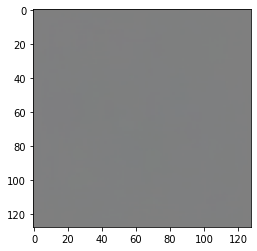

In [5]:
generated_images = model(noise, training=False)
gen_1 = generated_images[0].numpy()*127.5+127.5
plt.imshow((gen_1).astype("uint32"))

In [6]:
def add_downsampling_unit(model, units):
    model.add(
        Conv2D(filters=units[0], kernel_size=(3, 3),
            padding="same", activation="leaky_relu")
    )
    model.add(
        Conv2D(filters=units[1], kernel_size=(3, 3),
            padding="same", activation="leaky_relu")
    )
    model.add(AveragePooling2D())

def make_discriminator_model():
    model = Sequential()
    
    # out: 64x64x256
    model.add(
        Conv2D(filters=128, kernel_size=(3, 3),
            input_shape=(128, 128, 3), padding="same",
            activation="leaky_relu")
    )
    model.add(
        Conv2D(filters=256, kernel_size=(3, 3),
            padding="same", activation="leaky_relu")
    )
    model.add(AveragePooling2D())
    
    # out: 32x32x512
    add_downsampling_unit(model, (256, 512))
    
    # out: 16x16x512
    add_downsampling_unit(model, (512, 512))
    
    # out: 8x8x512
    add_downsampling_unit(model, (512, 512))
    
    # out: 4x4x512
    add_downsampling_unit(model, (512, 512))
    
    # out: last
    model.add(
        Conv2D(filters=512, kernel_size=(3, 3),
            padding="same", activation="leaky_relu")
    )
    model.add(
        Conv2D(filters=512, kernel_size=(4, 4), strides=4,
            padding="same", activation="leaky_relu")
    )
    
    model.add(Flatten())
    model.add(Activation("sigmoid"))

    return model

In [7]:
discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 128)     3584      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 256)     295168    
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 256)       590080    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 512)       1180160   
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 512)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 512)      